In [1]:
print("="*60)
print("CELL 1: INSTALLING PACKAGES")
print("="*60)

!pip install obonet -q
!pip install networkx -q

print("✓ Packages installed!")

print("="*60)
print("CELL 2: IMPORTING LIBRARIES")
print("="*60)

import os
import time
import csv
import numpy as np
import pandas as pd
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import networkx as nx
import obonet

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

print("="*60)
print("CELL 3: CONFIGURATION")
print("="*60)

# Basic configs
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 40
LR = 5e-4
WEIGHT_DECAY = 1e-4
CLIP_NORM = 5.0
FEATURE_DROPOUT = 0.2
LABEL_SMOOTH = 0.03
TOP_K = 500  # Tăng để có nhiều predictions

# Stage 1 configs
USE_PROPAGATION = True
USE_ENSEMBLE = True
USE_DYNAMIC_THRESH = True

# Paths
OUT_MODEL = "/kaggle/working/best_model.pt"
OUT_MODEL2 = "/kaggle/working/best_model2.pt"
OUT_SUBMIT = "/kaggle/working/submission_fixed.tsv"

# Set seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✓ Device: {DEVICE}")
print(f"✓ TOP_K: {TOP_K}")
print(f"✓ EPOCHS: {EPOCHS}")
print(f"✓ BATCH_SIZE: {BATCH_SIZE}")

print("="*60)
print("CELL 4: DOWNLOADING GO ONTOLOGY")
print("="*60)

go_file = '/kaggle/working/go-basic.obo'
if not os.path.exists(go_file):
    print("Downloading go-basic.obo...")
    !wget http://purl.obolibrary.org/obo/go/go-basic.obo -O {go_file} -q
    print("✓ Downloaded!")
else:
    print("✓ GO file already exists")

print(f"✓ GO file: {go_file}")

print("="*60)
print("CELL 5: LOADING DATA")
print("="*60)

X_train = np.load('/kaggle/input/cafa56-end/650_taxon_features_X_INPUT.npy')
X_test = np.load('/kaggle/input/cafa56-end/X_test.npy')
ids_test = np.load('/kaggle/input/cafa56-end/protein_ids_test.npy')
Y_sparse = load_npz("/kaggle/input/cafa56-end/Y_full.npz")
GO_terms = np.load("/kaggle/input/cafa56-end/GO_terms_full.npy", allow_pickle=True)
print(X_train.shape[0])
print(f"✓ X_train shape: {X_train.shape}")
print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ Y_sparse shape: {Y_sparse.shape}")
print(f"✓ Number of GO terms: {len(GO_terms)}")
print(f"✓ Number of test proteins: {len(ids_test)}")

# Kiểm tra format protein IDs
print(f"\n📋 Sample test IDs:")
for i in range(min(5, len(ids_test))):
    print(f"   {ids_test[i]}")

print("="*60)
print("CELL 6: PREPARING TRAIN/VAL SPLIT")
print("="*60)

# Normalization
global_mean = X_train.mean(axis=0).astype(np.float32)
global_std = X_train.std(axis=0).astype(np.float32) + 1e-6

# Train/Val split - chỉ lấy samples có labels
Y_sparse = Y_sparse.tocsr()
row_nnz = np.diff(Y_sparse.indptr)
valid_idx = np.where(row_nnz > 0)[0]
train_idx, val_idx = train_test_split(valid_idx, test_size=0.1, random_state=SEED, shuffle=True)

print(f"✓ Total samples with labels: {len(valid_idx)}")
print(f"✓ Train samples: {len(train_idx)}")
print(f"✓ Val samples: {len(val_idx)}")

# Pos weight for imbalanced classes
train_sparse = Y_sparse[train_idx]
label_freq = np.array(train_sparse.sum(axis=0)).squeeze()
N_train = len(train_idx)
pos_weight_arr = (N_train - label_freq) / (label_freq + 1e-8)
pos_weight_arr = np.clip(pos_weight_arr, 1.0, 5.0)
pos_weight = torch.tensor(pos_weight_arr, dtype=torch.float32).to(DEVICE)

print(f"✓ Pos weight range: [{pos_weight_arr.min():.2f}, {pos_weight_arr.max():.2f}]")

print("="*60)
print("CELL 7: LOADING IA VALUES & ONTOLOGY MAPPINGS")
print("="*60)

# IA values
IA_dict = {}
with open("/kaggle/input/cafa56-end/IA.tsv") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) == 2:
            go, value = parts
            IA_dict[go] = float(value)

IA_vec = np.array([IA_dict.get(go, 0.0) for go in GO_terms], dtype=np.float32)

# Kiểm tra IA
zero_ia_count = np.sum(IA_vec == 0)
print(f"✓ Loaded {len(IA_dict)} IA values")
print(f"⚠️ GO terms với IA=0: {zero_ia_count}/{len(GO_terms)}")

# Ontology mapping
go2asp = {}
with open("/kaggle/input/mapping-wf1/go_to_aspect.tsv") as f:
    next(f)  # skip header
    for line in f:
        parts = line.strip().split(",")
        if len(parts) == 2:
            go, asp = parts
            go2asp[go] = asp

idx_MF = np.array([i for i, go in enumerate(GO_terms) if go2asp.get(go) == "F"])
idx_CC = np.array([i for i, go in enumerate(GO_terms) if go2asp.get(go) == "C"])
idx_BP = np.array([i for i, go in enumerate(GO_terms) if go2asp.get(go) == "P"])

print(f"✓ MF terms: {len(idx_MF)}")
print(f"✓ CC terms: {len(idx_CC)}")
print(f"✓ BP terms: {len(idx_BP)}")

# GO term -> index mapping
go_to_idx = {go: i for i, go in enumerate(GO_terms)}

print("="*60)
print("CELL 8: LOADING GO GRAPH & BUILDING ANCESTOR CACHE")
print("="*60)

try:
    go_graph = obonet.read_obo(go_file)
    print(f"✓ GO graph loaded: {len(go_graph)} terms, {go_graph.number_of_edges()} edges")
    
    # Build ancestor cache
    print("Building ancestor cache (this may take a minute)...")
    
    def get_ancestors(go_term, graph, cache):
        """Lấy tất cả ancestors (bao gồm chính term đó)"""
        if go_term in cache:
            return cache[go_term]
        ancestors = set()
        if go_term in graph:
            ancestors.add(go_term)
            for parent in graph.successors(go_term):
                ancestors.update(get_ancestors(parent, graph, cache))
        cache[go_term] = ancestors
        return ancestors
    
    ancestor_cache = {}
    for i, go_term in enumerate(GO_terms):
        if i % 1000 == 0:
            print(f"  Processing {i}/{len(GO_terms)}...", end='\r')
        get_ancestors(go_term, go_graph, ancestor_cache)
    
    # Tạo ancestor_indices: go_idx -> list of ancestor indices trong dataset
    ancestor_indices = {}
    for i, go_term in enumerate(GO_terms):
        if go_term in ancestor_cache:
            anc_set = ancestor_cache[go_term]
            anc_idx = [go_to_idx[anc] for anc in anc_set if anc in go_to_idx]
            ancestor_indices[i] = anc_idx
    
    print(f"\n✓ Cached ancestors for {len(ancestor_indices)} GO terms")
    avg_ancestors = np.mean([len(v) for v in ancestor_indices.values()])
    print(f"✓ Average ancestors per term: {avg_ancestors:.1f}")
    
    GO_GRAPH_LOADED = True
    
except Exception as e:
    print(f"✗ Error loading GO graph: {e}")
    print("Propagation will be disabled")
    USE_PROPAGATION = False
    GO_GRAPH_LOADED = False
    ancestor_indices = {}

print("="*60)
print("CELL 9: DEFINING HELPER FUNCTIONS")
print("="*60)

def propagate_predictions(probs, ancestor_indices, top_k=500, verbose=True):
    """
    Propagate predictions lên GO hierarchy.
    Chỉ propagate top_k predictions để tăng tốc.
    """
    if not USE_PROPAGATION or len(ancestor_indices) == 0:
        return probs
    
    if verbose:
        print(f"Propagating predictions (top_k={top_k})...")
    
    propagated = probs.copy()
    n_samples = probs.shape[0]
    
    for i in range(n_samples):
        if verbose and i % 2000 == 0:
            print(f"  Progress: {i}/{n_samples}", end='\r')
        
        # Chỉ lấy top_k predictions thay vì tất cả
        top_indices = np.argsort(probs[i])[::-1][:top_k]
        
        for go_idx in top_indices:
            score = probs[i, go_idx]
            if score < 0.01:
                break  # Đã sorted, nên dừng sớm
            
            if go_idx in ancestor_indices:
                for anc_idx in ancestor_indices[go_idx]:
                    if propagated[i, anc_idx] < score:
                        propagated[i, anc_idx] = score
    
    if verbose:
        print(f"\n✓ Propagated {n_samples} samples")
    
    return propagated


def compute_cafa_f1(y_true, y_pred_bin, IA_vec, idx_list=None):
    """Tính CAFA weighted F1 score."""
    if idx_list is not None:
        y_true = y_true[:, idx_list]
        y_pred_bin = y_pred_bin[:, idx_list]
        weights = IA_vec[idx_list]
    else:
        weights = IA_vec
    
    precision_list = []
    recall_list = []
    
    for i in range(y_true.shape[0]):
        true_mask = y_true[i] > 0.5
        pred_mask = y_pred_bin[i] > 0.5
        tp_mask = true_mask & pred_mask
        
        tp_weight = weights[tp_mask].sum() if tp_mask.any() else 0.0
        pred_weight = weights[pred_mask].sum() if pred_mask.any() else 0.0
        true_weight = weights[true_mask].sum() if true_mask.any() else 0.0
        
        if pred_weight > 0:
            precision_list.append(tp_weight / pred_weight)
        if true_weight > 0:
            recall_list.append(tp_weight / true_weight)
    
    avg_precision = np.mean(precision_list) if precision_list else 0.0
    avg_recall = np.mean(recall_list) if recall_list else 0.0
    
    if avg_precision + avg_recall > 0:
        f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall)
    else:
        f1 = 0.0
    
    return f1, avg_precision, avg_recall

print("✓ Helper functions defined!")

print("="*60)
print("CELL 10: DEFINING DATASET & MODEL")
print("="*60)

class ProteinDataset(Dataset):
    def __init__(self, X, Y_sparse=None, indices=None, mean=None, std=None, 
                 feature_dropout=0.0, train=True):
        self.X = X
        self.Y = Y_sparse
        self.indices = np.array(indices) if indices is not None else np.arange(X.shape[0])
        self.mean = mean
        self.std = std
        self.feature_dropout = feature_dropout
        self.train = train

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = int(self.indices[idx])
        x = self.X[i].astype(np.float32)
        if self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
        if self.train and self.feature_dropout > 0.0 and np.random.rand() < 0.5:
            mask = (np.random.rand(x.shape[0]) >= self.feature_dropout).astype(np.float32)
            x = x * mask
        x = torch.from_numpy(x)
        if self.Y is not None:
            y = torch.from_numpy(self.Y[i].toarray().squeeze().astype(np.float32))
            return x, y
        else:
            return x


class DeepGO_MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=[2048, 1024, 512], dropout=0.3):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

print("✓ Dataset and Model classes defined!")

print("="*60)
print("CELL 11: CREATING DATALOADERS & MODEL")
print("="*60)

train_ds = ProteinDataset(X_train, Y_sparse, train_idx, global_mean, global_std, 
                          FEATURE_DROPOUT, True)
val_ds = ProteinDataset(X_train, Y_sparse, val_idx, global_mean, global_std, 0.0, False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=2, pin_memory=True)

model = DeepGO_MLP(X_train.shape[1], Y_sparse.shape[1]).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters())

print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Val loader: {len(val_loader)} batches")
print(f"✓ Model parameters: {n_params:,}")

print("="*60)
print("CELL 12: DEFINING TRAINING FUNCTIONS")
print("="*60)

def bce_label_smooth(logits, targets, pos_weight=None, eps=LABEL_SMOOTH):
    smooth_pos = 1.0 - eps
    smooth_neg = eps * 0.5
    targets_sm = targets * smooth_pos + (1 - targets) * smooth_neg
    criterion = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)
    loss = criterion(logits, targets_sm)
    return loss.mean()


@torch.no_grad()
def eval_model(model, loader, pos_weight, threshold=0.1):
    """Evaluate model (không propagate để nhanh)."""
    all_probs = []
    all_labels = []
    total_loss = 0.0
    n_samples = 0
    
    model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = bce_label_smooth(logits, yb, pos_weight)
        total_loss += float(loss.item()) * xb.size(0)
        n_samples += xb.size(0)
        
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(yb.cpu().numpy())
    
    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    val_loss = total_loss / n_samples
    
    # Apply threshold
    y_pred_bin = (all_probs >= threshold).astype(float)
    
    # Compute F1 per ontology
    f1_mf, _, _ = compute_cafa_f1(all_labels, y_pred_bin, IA_vec, idx_MF)
    f1_cc, _, _ = compute_cafa_f1(all_labels, y_pred_bin, IA_vec, idx_CC)
    f1_bp, _, _ = compute_cafa_f1(all_labels, y_pred_bin, IA_vec, idx_BP)
    f1_avg = (f1_mf + f1_cc + f1_bp) / 3
    
    return val_loss, f1_mf, f1_cc, f1_bp, f1_avg
def compute_cafa_f1_batch(y_true, y_pred_bin, ia_weights):
    tp_weighted = (y_true * y_pred_bin) * ia_weights
    tp_sum = tp_weighted.sum(axis=1)
    pred_weighted = y_pred_bin * ia_weights
    pred_sum = pred_weighted.sum(axis=1)
    true_weighted = y_true * ia_weights
    true_sum = true_weighted.sum(axis=1)
    
    # 1. Tính Precision & Recall cho từng mẫu
    precision = np.zeros_like(tp_sum)
    recall = np.zeros_like(tp_sum)
    np.divide(tp_sum, pred_sum, out=precision, where=pred_sum > 0)
    np.divide(tp_sum, true_sum, out=recall, where=true_sum > 0)
    
    # 2. Lấy TRUNG BÌNH Precision và Recall TRƯỚC (Đây là điểm khác biệt)
    avg_precision = precision.mean()
    avg_recall = recall.mean()
    
    # 3. Tính F1 từ hai số trung bình đó
    if (avg_precision + avg_recall) > 0:
        f1_score = 2 * avg_precision * avg_recall / (avg_precision + avg_recall)
    else:
        f1_score = 0.0
    return f1_score
print("✓ Training functions defined!")

CELL 1: INSTALLING PACKAGES
✓ Packages installed!
CELL 2: IMPORTING LIBRARIES
✓ All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True
CELL 3: CONFIGURATION
✓ Device: cuda
✓ TOP_K: 500
✓ EPOCHS: 40
✓ BATCH_SIZE: 16
CELL 4: DOWNLOADING GO ONTOLOGY
✓ Downloaded!
✓ GO file: /kaggle/working/go-basic.obo
CELL 5: LOADING DATA
144096
✓ X_train shape: (144096, 1291)
✓ X_test shape: (224309, 1291)
✓ Y_sparse shape: (144096, 32347)
✓ Number of GO terms: 32347
✓ Number of test proteins: 224309

📋 Sample test IDs:
   A0A0C5B5G6
   A0A1B0GTW7
   A0JNW5
   A0JP26
   A0PK11
CELL 6: PREPARING TRAIN/VAL SPLIT
✓ Total samples with labels: 144096
✓ Train samples: 129686
✓ Val samples: 14410
✓ Pos weight range: [1.00, 5.00]
CELL 7: LOADING IA VALUES & ONTOLOGY MAPPINGS
✓ Loaded 40122 IA values
⚠️ GO terms với IA=0: 9499/32347
✓ MF terms: 6616
✓ CC terms: 2651
✓ BP terms: 16858
CELL 8: LOADING GO GRAPH & BUILDING ANCESTOR CACHE
✓ GO graph loaded: 39354 terms, 74763 edges
Building ancesto

CELL 13: TRAINING MULTI-TASK (BATCH 128 | LR 1e-3 | THRESH 0.1)
Loading Data...
🚀 Start Training (60 epochs) | Batch 128 | LR 0.001
[Ep  1] TrLoss=0.0485 | ValLoss=0.0171 | F1=0.1756 | 33s -> 🔥 Saved Best
[Ep  2] TrLoss=0.0176 | ValLoss=0.0149 | F1=0.2130 | 30s -> 🔥 Saved Best
[Ep  3] TrLoss=0.0154 | ValLoss=0.0137 | F1=0.2339 | 31s -> 🔥 Saved Best
[Ep  4] TrLoss=0.0141 | ValLoss=0.0129 | F1=0.2388 | 30s -> 🔥 Saved Best
[Ep  5] TrLoss=0.0132 | ValLoss=0.0124 | F1=0.2456 | 30s -> 🔥 Saved Best
[Ep  6] TrLoss=0.0126 | ValLoss=0.0120 | F1=0.2531 | 31s -> 🔥 Saved Best
[Ep  7] TrLoss=0.0122 | ValLoss=0.0119 | F1=0.2593 | 31s -> 🔥 Saved Best
[Ep  8] TrLoss=0.0118 | ValLoss=0.0116 | F1=0.2620 | 31s -> 🔥 Saved Best
[Ep  9] TrLoss=0.0116 | ValLoss=0.0115 | F1=0.2608 | 31s
[Ep 10] TrLoss=0.0113 | ValLoss=0.0113 | F1=0.2674 | 31s -> 🔥 Saved Best
[Ep 11] TrLoss=0.0111 | ValLoss=0.0112 | F1=0.2644 | 31s
[Ep 12] TrLoss=0.0109 | ValLoss=0.0111 | F1=0.2651 | 31s
[Ep 13] TrLoss=0.0107 | ValLoss=0.0111 |

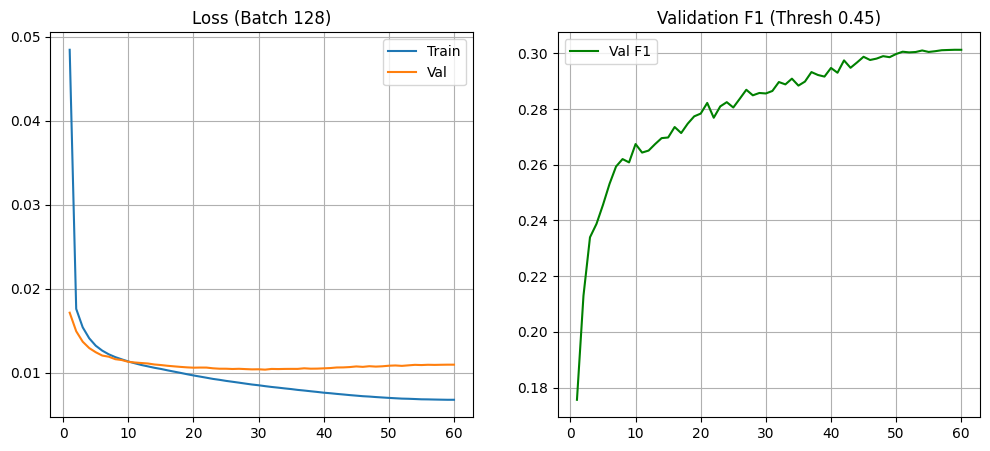


✅ COMPLETE. Best F1: 0.3013


In [2]:
# ============================================================================
# CELL 13: TRAIN MULTI-TASK (FINAL CONFIG: BATCH 128 - LR 1e-3)
# ============================================================================
print("="*60)
print("CELL 13: TRAINING MULTI-TASK (BATCH 128 | LR 1e-3 | THRESH 0.1)")
print("="*60)

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import gc
import os

# --- CẤU HÌNH ĐÃ CHỐT ---
BATCH_SIZE = 128      
LR = 1e-3             
EPOCHS = 60           
DROPOUT_RATE = 0.4    
WEIGHT_DECAY = 1e-2   # L2 Regularization
VAL_THRESHOLD = 0.45   

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_MODEL = "/kaggle/working/multitask_best_model.pt"

# 1. LOAD DATA & MAPPING
if 'X_train_full' not in locals():
    print("Loading Data...")
    X_train_full = np.load('/kaggle/input/cafa56-end/650_taxon_features_X_INPUT.npy')
    Y_sparse_full = load_npz("/kaggle/input/cafa56-end/Y_full.npz")
    GO_terms_full = np.load("/kaggle/input/cafa56-end/GO_terms_full.npy", allow_pickle=True)

Y_sparse_full = Y_sparse_full.tocsr()

go2asp = {}
with open("/kaggle/input/mapping-wf1/go_to_aspect.tsv") as f:
    next(f)
    for line in f:
        go, asp = line.strip().split(",")
        go2asp[go] = asp

# --- LOAD IA VECTOR ---
if 'IA_vec' not in locals():
    print("Loading IA Weights...")
    IA_dict = {}
    with open("/kaggle/input/cafa56-end/IA.tsv") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                IA_dict[parts[0]] = float(parts[1])
    IA_vec = np.array([IA_dict.get(go, 0.0) for go in GO_terms_full], dtype=np.float32)

# Chuẩn hóa Input
global_mean = X_train_full.mean(axis=0).astype(np.float32)
global_std  = X_train_full.std(axis=0).astype(np.float32) + 1e-6

# 2. INDICES & POS WEIGHTS
idx_F = [i for i, go in enumerate(GO_terms_full) if go2asp.get(go) == 'F']
idx_C = [i for i, go in enumerate(GO_terms_full) if go2asp.get(go) == 'C']
idx_P = [i for i, go in enumerate(GO_terms_full) if go2asp.get(go) == 'P']

t_idx_F = torch.tensor(idx_F, device=DEVICE)
t_idx_C = torch.tensor(idx_C, device=DEVICE)
t_idx_P = torch.tensor(idx_P, device=DEVICE)

def get_pos_weight(indices):
    sub_Y = Y_sparse_full[:, indices]
    freq = np.array(sub_Y.sum(axis=0)).squeeze()
    weight = (sub_Y.shape[0] - freq) / (freq + 1e-5)
    return torch.tensor(np.clip(weight, 1.0, 5.0), dtype=torch.float32).to(DEVICE)

pw_F, pw_C, pw_P = get_pos_weight(idx_F), get_pos_weight(idx_C), get_pos_weight(idx_P)


# 4. FOCAL LOSS & MODEL
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, pos_weight=None):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        ce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, pos_weight=self.pos_weight, reduction='none'
        )
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        return (focal_weight * ce_loss).mean()

# Dataset
class ProteinDataset(Dataset):
    def __init__(self, X, Y_sparse=None, indices=None, train=True):
        self.X = X; self.Y = Y_sparse; self.indices = indices; self.train = train
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        i = self.indices[idx]
        x = (self.X[i].astype(np.float32) - global_mean) / global_std
        # Augmentation
        if self.train and np.random.rand() < 0.5:
            mask = (np.random.rand(x.shape[0]) >= 0.2).astype(np.float32)
            x = x * mask
        x = torch.from_numpy(x)
        y = torch.from_numpy(self.Y[i].toarray().squeeze().astype(np.float32))
        return x, y

# Model (Dropout 0.4)
class MultiTaskDeepGO(nn.Module):
    def __init__(self, input_dim, num_f, num_c, num_p):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 2048), nn.LayerNorm(2048), nn.GELU(), nn.Dropout(DROPOUT_RATE),
            nn.Linear(2048, 1024), nn.LayerNorm(1024), nn.GELU(), nn.Dropout(DROPOUT_RATE),
            nn.Linear(1024, 1024), nn.LayerNorm(1024), nn.GELU(), nn.Dropout(DROPOUT_RATE)
        )
        self.head_f = nn.Sequential(nn.Linear(1024, 512), nn.GELU(), nn.Dropout(0.2), nn.Linear(512, num_f))
        self.head_c = nn.Sequential(nn.Linear(1024, 512), nn.GELU(), nn.Dropout(0.2), nn.Linear(512, num_c))
        self.head_p = nn.Sequential(nn.Linear(1024, 512), nn.GELU(), nn.Dropout(0.2), nn.Linear(512, num_p))

    def forward(self, x):
        h = self.shared(x)
        return self.head_f(h), self.head_c(h), self.head_p(h)

# 6. SETUP
train_idx, val_idx = train_test_split(np.arange(X_train_full.shape[0]), test_size=0.1, random_state=42)

train_ds = ProteinDataset(X_train_full, Y_sparse_full, train_idx, train=True)
val_ds = ProteinDataset(X_train_full, Y_sparse_full, val_idx, train=False)

# Batch 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

model = MultiTaskDeepGO(X_train_full.shape[1], len(idx_F), len(idx_C), len(idx_P)).to(DEVICE)

# Optimizer LR 1e-3 & Weight Decay 1e-2
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader))
scaler = torch.amp.GradScaler('cuda')

criterion_focal_F = FocalLoss(gamma=2.0, pos_weight=pw_F)
criterion_focal_C = FocalLoss(gamma=2.0, pos_weight=pw_C)
criterion_focal_P = FocalLoss(gamma=2.0, pos_weight=pw_P)

w_mf = IA_vec[idx_F]; w_cc = IA_vec[idx_C]; w_bp = IA_vec[idx_P]

# 7. TRAINING LOOP
print(f"🚀 Start Training ({EPOCHS} epochs) | Batch {BATCH_SIZE} | LR {LR}")
best_score = 0.0
total_start = time.time()
train_loss_hist, val_loss_hist, val_f1_hist = [], [], []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    
    # === TRAIN ===
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            out_f, out_c, out_p = model(xb)
            y_f, y_c, y_p = yb[:, t_idx_F], yb[:, t_idx_C], yb[:, t_idx_P]
            loss = criterion_focal_F(out_f, y_f) + criterion_focal_C(out_c, y_c) + 1.2 * criterion_focal_P(out_p, y_p)
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update(); scheduler.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    
    # === EVAL ===
    model.eval()
    val_loss = 0; val_f1_accum = 0; n_val = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            out_f, out_c, out_p = model(xb)
            y_f, y_c, y_p = yb[:, t_idx_F], yb[:, t_idx_C], yb[:, t_idx_P]
            
            l_val = criterion_focal_F(out_f, y_f) + criterion_focal_C(out_c, y_c) + 1.2 * criterion_focal_P(out_p, y_p)
            val_loss += l_val.item()
            
            # Threshold 0.1
            p_f = (torch.sigmoid(out_f) > VAL_THRESHOLD).float().cpu().numpy()
            p_c = (torch.sigmoid(out_c) > VAL_THRESHOLD).float().cpu().numpy()
            p_p = (torch.sigmoid(out_p) > VAL_THRESHOLD).float().cpu().numpy()
            y_np = yb.cpu().numpy()
            
            f1_f = compute_cafa_f1_batch(y_np[:, idx_F], p_f, w_mf)
            f1_c = compute_cafa_f1_batch(y_np[:, idx_C], p_c, w_cc)
            f1_p = compute_cafa_f1_batch(y_np[:, idx_P], p_p, w_bp)
            
            val_f1_accum += (f1_f + f1_c + f1_p) / 3
            n_val += 1
            
    avg_val_loss = val_loss / n_val
    avg_f1 = val_f1_accum / n_val
    dt = time.time() - t0
    
    train_loss_hist.append(avg_train_loss)
    val_loss_hist.append(avg_val_loss)
    val_f1_hist.append(avg_f1)
    
    print(f"[Ep {epoch:2d}] TrLoss={avg_train_loss:.4f} | ValLoss={avg_val_loss:.4f} | F1={avg_f1:.4f} | {dt:.0f}s", end="")
    
    if avg_f1 > best_score:
        best_score = avg_f1
        torch.save({
            "model_state": model.state_dict(),
            "indices": {"F": idx_F, "C": idx_C, "P": idx_P},
            "best_f1": best_score
        }, OUT_MODEL)
        print(" -> 🔥 Saved Best")
    else:
        print()

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, label='Train')
plt.plot(range(1, len(val_loss_hist)+1), val_loss_hist, label='Val')
plt.title('Loss (Batch 128)'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_f1_hist)+1), val_f1_hist, label='Val F1', color='green')
plt.title(f'Validation F1 (Thresh {VAL_THRESHOLD})'); plt.legend(); plt.grid(True)
plt.show()

print(f"\n✅ COMPLETE. Best F1: {best_score:.4f}")
del model, optimizer, train_loader, val_loader
gc.collect(); torch.cuda.empty_cache()

In [3]:
# ============================================================================
# CELL 15: PREDICT MULTI-TASK -> MERGE TO 'test_preds.dat'
# ============================================================================
print("="*60)
print("CELL 15: PREDICTING WITH MULTI-TASK MODEL")
print("="*60)

import gc
import os
import numpy as np
import torch
from torch.utils.data import DataLoader

# Cấu hình Output
PRED_FILE = "/kaggle/working/test_preds.dat"
MODEL_PATH = "/kaggle/working/multitask_best_model.pt"

# Load Data nếu thiếu
if 'X_test' not in locals():
    print("Loading Test Data...")
    X_test = np.load('/kaggle/input/cafa56-end/X_test.npy')
    ids_test = np.load('/kaggle/input/cafa56-end/protein_ids_test.npy')
    GO_terms_full = np.load("/kaggle/input/cafa56-end/GO_terms_full.npy", allow_pickle=True)
    X_ref = np.load('/kaggle/input/cafa56-end/650_taxon_features_X_INPUT.npy')
    global_mean = X_ref.mean(axis=0).astype(np.float32)
    global_std  = X_ref.std(axis=0).astype(np.float32) + 1e-6
    del X_ref; gc.collect()

SHAPE = (len(X_test), len(GO_terms_full))

# Tạo file memmap rỗng
if os.path.exists(PRED_FILE): os.remove(PRED_FILE)
final_probs = np.memmap(PRED_FILE, dtype='float16', mode='w+', shape=SHAPE)

# Loader
class TestDataset(Dataset):
    def __init__(self, X): self.X = X
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = (self.X[idx].astype(np.float32) - global_mean) / global_std
        return torch.from_numpy(x)

test_loader = DataLoader(TestDataset(X_test), batch_size=256, shuffle=False, num_workers=2)

# Load Model
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("❌ Chưa train xong model! Hãy chạy Cell 13 trước.")

print(f"Loading Model: {MODEL_PATH}")
ckpt = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
indices = ckpt["indices"]

model = MultiTaskDeepGO(
    input_dim=X_test.shape[1],
    num_f=len(indices["F"]),
    num_c=len(indices["C"]),
    num_p=len(indices["P"])
).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

# Indices
idx_f = np.array(indices["F"])
idx_c = np.array(indices["C"])
idx_p = np.array(indices["P"])

print("🚀 Predicting...")
start_idx = 0

with torch.no_grad():
    for i, xb in enumerate(test_loader):
        xb = xb.to(DEVICE)
        
        # Forward pass (1 lần ra 3 kết quả)
        out_f, out_c, out_p = model(xb)
        
        # Sigmoid
        p_f = torch.sigmoid(out_f).cpu().numpy().astype(np.float16)
        p_c = torch.sigmoid(out_c).cpu().numpy().astype(np.float16)
        p_p = torch.sigmoid(out_p).cpu().numpy().astype(np.float16)
        
        end_idx = start_idx + p_f.shape[0]
        
        # Ghi vào Memmap
        current_block = final_probs[start_idx:end_idx]
        current_block[:, idx_f] = p_f
        current_block[:, idx_c] = p_c
        current_block[:, idx_p] = p_p
        final_probs[start_idx:end_idx] = current_block
        
        start_idx = end_idx
        if i % 100 == 0: print(f"  Batch {i}/{len(test_loader)}", end='\r')

final_probs.flush()
print(f"\n✅ PREDICTION COMPLETE! Output: {PRED_FILE}")

CELL 15: PREDICTING WITH MULTI-TASK MODEL
Loading Model: /kaggle/working/multitask_best_model.pt
🚀 Predicting...
  Batch 800/877
✅ PREDICTION COMPLETE! Output: /kaggle/working/test_preds.dat


In [4]:
# ============================================================================
# CELL 15.1: INSTALL PYG & BUILD GRAPH
# ============================================================================
print("🛠️ STEP 1: GNN SETUP...")

import torch
import numpy as np
import obonet
import os

try:
    import torch_geometric
    print(f"✓ Found PyG version: {torch_geometric.__version__}")
except ImportError:
    print("⏳ Installing PyTorch Geometric...")
    !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html -q
    !pip install torch-geometric -q

print("   Building Graph Edges...")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if 'GO_terms_full' not in globals():
    try: GO_terms_full = np.load("/kaggle/input/cafa56-end/GO_terms_full.npy", allow_pickle=True)
    except: pass

if 'go_graph' not in globals():
    go_file = '/kaggle/working/go-basic.obo'
    if not os.path.exists(go_file):
        !wget http://purl.obolibrary.org/obo/go/go-basic.obo -O {go_file} -q
    go_graph = obonet.read_obo(go_file)

def build_edge_index(go_terms, graph, device):
    go2idx = {go: i for i, go in enumerate(go_terms)}
    edges = []
    for go in go_terms:
        if go in graph:
            for parent in graph.successors(go):
                if parent in go2idx:
                    src, dst = go2idx[go], go2idx[parent]
                    edges.append([src, dst]); edges.append([dst, src])
    if len(edges) == 0: return torch.zeros((2, 0), dtype=torch.long).to(device)
    return torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)

if 'GO_terms_full' in globals():
    EDGE_INDEX = build_edge_index(GO_terms_full, go_graph, DEVICE)
    print(f"✅ GRAPH READY: {len(GO_terms_full)} Nodes | {EDGE_INDEX.shape[1]} Edges")

🛠️ STEP 1: GNN SETUP...
⏳ Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
   Building Graph Edges...
✅ GRAPH READY: 32347 Nodes | 113984 Edges


In [5]:
# ============================================================================
# CELL 15.2: DEFINE GNN MODEL ARCHITECTURE
# ============================================================================
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class DeepGO_GNN(nn.Module):
    def __init__(self, input_dim, num_classes, edge_index, embed_dim=1024):
        super().__init__()
        self.edge_index = edge_index
        self.protein_encoder = nn.Sequential(
            nn.Linear(input_dim, 2048), nn.LayerNorm(2048), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(2048, 1024), nn.LayerNorm(1024), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(1024, 1024), nn.LayerNorm(1024), nn.GELU() 
        )
        self.go_embed = nn.Parameter(torch.empty(num_classes, embed_dim))
        nn.init.xavier_uniform_(self.go_embed)
        self.gcn1 = GCNConv(embed_dim, embed_dim)
        self.gcn2 = GCNConv(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        prot_feat = self.protein_encoder(x)
        label_feat = self.gcn1(self.go_embed, self.edge_index)
        label_feat = F.relu(label_feat); label_feat = self.dropout(label_feat)
        label_feat = self.gcn2(label_feat, self.edge_index)
        logits = torch.matmul(prot_feat, label_feat.t())
        return logits

print("✅ GNN Architecture Defined!")

✅ GNN Architecture Defined!


CELL 15.3: TRAINING GNN (BATCH 128 - THRESH 0.45)
[*] Initializing GNN...
[+] Transferred layers from MLP!
🔒 Encoder FROZEN (Safe Mode)
[*] Training GNN (25 epochs)...
  [Ep 1] Batch 1000/1014 | Loss: 0.0069
  -> Train=0.0206 | Val=0.0075 | F1=0.0924 (Thresh 0.45) | 168s -> 🔥 BEST
  [Ep 2] Batch 1000/1014 | Loss: 0.0037
  -> Train=0.0052 | Val=0.0048 | F1=0.2291 (Thresh 0.45) | 167s -> 🔥 BEST
  [Ep 3] Batch 1000/1014 | Loss: 0.0042
  -> Train=0.0039 | Val=0.0043 | F1=0.2467 (Thresh 0.45) | 167s -> 🔥 BEST
  [Ep 4] Batch 1000/1014 | Loss: 0.0032
  -> Train=0.0036 | Val=0.0041 | F1=0.2580 (Thresh 0.45) | 167s -> 🔥 BEST
  [Ep 5] Batch 1000/1014 | Loss: 0.0035
  -> Train=0.0034 | Val=0.0041 | F1=0.2450 (Thresh 0.45) | 166s
  [Ep 6] Batch 1000/1014 | Loss: 0.0033
  -> Train=0.0033 | Val=0.0038 | F1=0.2659 (Thresh 0.45) | 166s -> 🔥 BEST
  [Ep 7] Batch 1000/1014 | Loss: 0.0034
  -> Train=0.0031 | Val=0.0037 | F1=0.2642 (Thresh 0.45) | 166s
  [Ep 8] Batch 1000/1014 | Loss: 0.0033
  -> Train=0.0

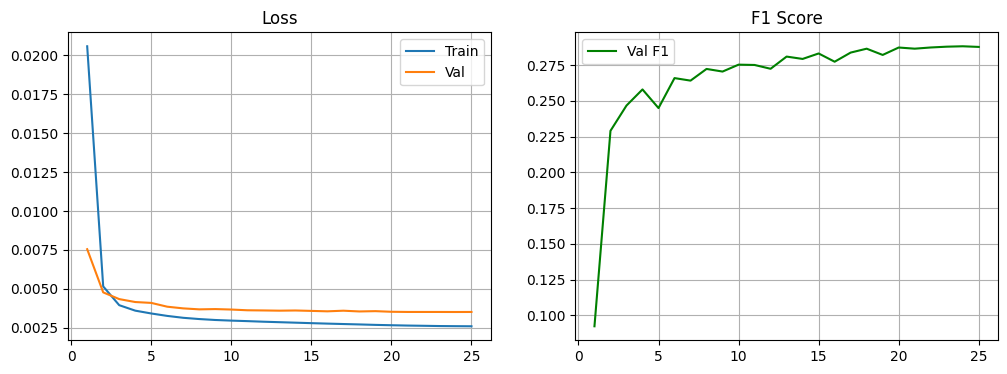


[+] DONE. Best F1: 0.2882


In [6]:
# ============================================================================
# CELL 15.3: TRAIN GNN (FULL RUN - NO TIME LIMIT)
# ============================================================================
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import os
import gc
import time
import numpy as np
import torch

# --- CẤU HÌNH ---
GNN_EPOCHS = 25       # Chạy đủ 25 epochs
GNN_LR = 1e-3         # LR tối ưu cho Batch lớn
BATCH_SIZE = 128      # Batch size
VAL_THRESHOLD = 0.45  

PRETRAINED_PATH = "/kaggle/working/multitask_best_model.pt" 
OUT_GNN_MODEL = "/kaggle/working/best_gnn_model.pt"

print("="*60)
print(f"CELL 15.3: TRAINING GNN (BATCH {BATCH_SIZE} - THRESH {VAL_THRESHOLD})")
print("="*60)

# --- 1. LOAD DATA ---
if 'X_train_full' not in globals():
    print("Loading X data...")
    X_train_full = np.load('/kaggle/input/cafa56-end/650_taxon_features_X_INPUT.npy')

if 'global_mean' not in globals():
    global_mean = X_train_full.mean(axis=0).astype(np.float32)
    global_std = X_train_full.std(axis=0).astype(np.float32) + 1e-6

if 'Y_sparse_full' not in globals():
    print("Loading Y data...")
    Y_sparse_full = load_npz("/kaggle/input/cafa56-end/Y_full.npz")
    
if 'GO_terms_full' not in globals():
    GO_terms_full = np.load("/kaggle/input/cafa56-end/GO_terms_full.npy", allow_pickle=True)
    if 'EDGE_INDEX' not in globals() and 'build_edge_index' in globals():
         EDGE_INDEX = build_edge_index(GO_terms_full, go_graph, DEVICE)

Y_sparse_full = Y_sparse_full.tocsr()

# Dataset
class SimpleDataset(Dataset):
    def __init__(self, X, Y, indices=None, train=True):
        self.X = X; self.Y = Y
        self.indices = indices if indices is not None else np.arange(len(X))
        self.train = train
    def __len__(self): return len(self.indices)
    def __getitem__(self, idx):
        i = self.indices[idx]
        x = (self.X[i].astype(np.float32) - global_mean) / global_std
        if self.train and np.random.rand() < 0.5:
            mask = (np.random.rand(x.shape[0]) >= 0.2).astype(np.float32)
            x = x * mask
        if hasattr(self.Y[i], 'toarray'): y = self.Y[i].toarray().squeeze()
        else: y = self.Y[i]
        return torch.from_numpy(x), torch.from_numpy(y.astype(np.float32))

# Loaders
train_idx, val_idx = train_test_split(np.arange(len(X_train_full)), test_size=0.1, random_state=42)

train_loader = DataLoader(SimpleDataset(X_train_full, Y_sparse_full, train_idx, True), 
                          batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=2, pin_memory=True, persistent_workers=True)

val_loader = DataLoader(SimpleDataset(X_train_full, Y_sparse_full, val_idx, False), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=2, pin_memory=True, persistent_workers=True)

# IA Weights
if 'IA_vec' in globals():
    w_mf = IA_vec[idx_F]; w_cc = IA_vec[idx_C]; w_bp = IA_vec[idx_P]

# --- 2. MODEL & FREEZE ---
print("[*] Initializing GNN...")
model_gnn = DeepGO_GNN(X_train_full.shape[1], len(GO_terms_full), EDGE_INDEX).to(DEVICE)

# Load Pretrained
if os.path.exists(PRETRAINED_PATH):
    ckpt = torch.load(PRETRAINED_PATH, map_location=DEVICE, weights_only=False)
    if isinstance(ckpt, dict) and 'model_state' in ckpt: state = ckpt['model_state']
    else: state = ckpt
    
    transfer_dict = {}
    for k, v in state.items():
        if "shared" in k:
            new_key = k.replace("shared", "protein_encoder")
            if new_key in model_gnn.state_dict() and v.shape == model_gnn.state_dict()[new_key].shape:
                transfer_dict[new_key] = v
                
    model_gnn.load_state_dict(transfer_dict, strict=False)
    print(f"[+] Transferred layers from MLP!")
    
    # FREEZE
    for name, param in model_gnn.named_parameters():
        if "protein_encoder" in name: param.requires_grad = False
    print(f"🔒 Encoder FROZEN (Safe Mode)")
else:
    print(f"[!] MLP not found at {PRETRAINED_PATH}")

# Focal Loss
if 'criterion' not in globals():
    freq_all = np.array(Y_sparse_full.sum(axis=0)).squeeze()
    pw_all = (Y_sparse_full.shape[0] - freq_all) / (freq_all + 1e-5)
    pw_all = torch.tensor(np.clip(pw_all, 1.0, 5.0), dtype=torch.float32).to(DEVICE)
    criterion = FocalLoss(gamma=2.0, pos_weight=pw_all)

# Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_gnn.parameters()), lr=GNN_LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=GNN_LR, epochs=GNN_EPOCHS, steps_per_epoch=len(train_loader))
scaler = torch.amp.GradScaler('cuda')

# --- 3. TRAINING LOOP (NO TIME LIMIT) ---
print(f"[*] Training GNN ({GNN_EPOCHS} epochs)...")
best_f1 = 0.0
total_start = time.time()
train_loss_history, val_loss_history, val_f1_history = [], [], []

for epoch in range(1, GNN_EPOCHS + 1):
    t0 = time.time()
    
    # === TRAIN ===
    model_gnn.train()
    train_loss = 0
    
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            loss = criterion(model_gnn(xb), yb)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model_gnn.parameters(), 1.0)
        scaler.step(optimizer); scaler.update(); scheduler.step()
        
        train_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f"\r  [Ep {epoch}] Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}", end="", flush=True)
    
    print() 
    
    # === VAL ===
    model_gnn.eval()
    val_loss = 0; val_f1_sum = 0; n_val = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            logits = model_gnn(xb)
            val_loss += criterion(logits, yb).item()
            
            probs = torch.sigmoid(logits).cpu().numpy()
            y_np = yb.cpu().numpy()
            
            # --- SỬ DỤNG VAL_THRESHOLD ĐÃ CHỈNH (0.45) ---
            preds_bin = (probs > VAL_THRESHOLD).astype(float)
            
            f1_mf = compute_cafa_f1_batch(y_np[:, idx_F], preds_bin[:, idx_F], w_mf)
            f1_cc = compute_cafa_f1_batch(y_np[:, idx_C], preds_bin[:, idx_C], w_cc)
            f1_bp = compute_cafa_f1_batch(y_np[:, idx_P], preds_bin[:, idx_P], w_bp)
            val_f1_sum += (f1_mf + f1_cc + f1_bp) / 3
            n_val += 1
    
    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    avg_f1 = val_f1_sum / n_val
    dt = time.time() - t0
    
    train_loss_history.append(avg_train)
    val_loss_history.append(avg_val)
    val_f1_history.append(avg_f1)
    
    print(f"  -> Train={avg_train:.4f} | Val={avg_val:.4f} | F1={avg_f1:.4f} (Thresh {VAL_THRESHOLD}) | {dt:.0f}s", end="")
    
    if avg_f1 > best_f1:
        best_f1 = avg_f1
        torch.save(model_gnn.state_dict(), OUT_GNN_MODEL)
        print(" -> 🔥 BEST")
    else:
        print()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train')
axes[0].plot(range(1, len(val_loss_history)+1), val_loss_history, label='Val')
axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(range(1, len(val_f1_history)+1), val_f1_history, label='Val F1', color='green')
axes[1].set_title('F1 Score'); axes[1].legend(); axes[1].grid(True)
plt.show()

print(f"\n[+] DONE. Best F1: {best_f1:.4f}")
del train_loader, val_loader, optimizer
gc.collect(); torch.cuda.empty_cache()

In [7]:
# ============================================================================
# CELL 15.4: PREDICT GNN & ENSEMBLE IN-PLACE (DISK SAFE MODE)
# ============================================================================
print("🚀 GNN PREDICTION & ENSEMBLE (IN-PLACE UPDATE)...")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

# --- Load pretrained models ---
GNN_MODEL_PATH = "/kaggle/working/best_gnn_model.pt"
MLP_MODEL_PATH = "/kaggle/working/multitask_best_model.pt"

if 'X_test' not in globals():
    X_test = np.load('/kaggle/input/cafa56-end/X_test.npy')

class TestDatasetSimple(Dataset):
    def __init__(self, X):
        self.X = X
        self.mean = X.mean(axis=0).astype(np.float32)
        self.std = X.std(axis=0).astype(np.float32) + 1e-6
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = (self.X[idx].astype(np.float32) - self.mean) / self.std
        return torch.from_numpy(x), torch.tensor(0.0)

# Cấu hình file
TARGET_FILE = "/kaggle/working/test_preds.dat"
if not os.path.exists(TARGET_FILE):
    raise FileNotFoundError("❌ Thiếu file test_preds.dat! Hãy chạy Cell 15 trước.")

# Mở file ở chế độ ĐỌC + GHI
SHAPE = (len(X_test), len(GO_terms_full))
preds_memmap = np.memmap(TARGET_FILE, dtype='float16', mode='r+', shape=SHAPE)

# Loader
test_loader = DataLoader(TestDatasetSimple(X_test), batch_size=32, shuffle=False, num_workers=2)

# Load GNN model
model_gnn.load_state_dict(torch.load(GNN_MODEL_PATH, map_location=DEVICE))
model_gnn.eval()

print(f"Mixing 50% MLP + 50% GNN...")
start_idx = 0
with torch.no_grad():
    for i, (xb, _) in enumerate(test_loader):
        xb = xb.to(DEVICE)
        
        # 1. GNN Predict
        logits = model_gnn(xb)
        gnn_probs = torch.sigmoid(logits).cpu().numpy()
        
        end_idx = start_idx + gnn_probs.shape[0]
        
        # 2. Load MLP Preds (from disk)
        mlp_probs = preds_memmap[start_idx:end_idx].astype(np.float32)
        
        # 3. Ensemble
        ensemble_probs = gnn_probs*0.5+0.5*mlp_probs
        
        # 4. Write Back
        preds_memmap[start_idx:end_idx] = ensemble_probs.astype(np.float16)
        
        start_idx = end_idx
        if i % 100 == 0: print(f"  Processed {i}/{len(test_loader)} batches...", end='\r')

preds_memmap.flush()
print(f"\n✅ ENSEMBLE COMPLETED IN-PLACE!")
print(f"   File '{TARGET_FILE}' now contains 0.5*MLP + 0.5*GNN")

🚀 GNN PREDICTION & ENSEMBLE (IN-PLACE UPDATE)...
Mixing 50% MLP + 50% GNN...
  Processed 7000/7010 batches...
✅ ENSEMBLE COMPLETED IN-PLACE!
   File '/kaggle/working/test_preds.dat' now contains 0.5*MLP + 0.5*GNN


In [8]:
# ============================================================================
# CELL 16: PROPAGATION (DISK OPTIMIZED - IN PLACE)
# ============================================================================
print("="*60)
print("CELL 16: PROPAGATING (NO EXTRA DISK SPACE)")
print("="*60)

import os
import gc

# 1. Cấu hình file
PRED_FILE = "/kaggle/working/test_preds.dat"
# Shape bắt buộc phải khớp với lúc tạo file
SHAPE = (224309, 32347) # (Số Protein Test, Số GO Terms)

# 2. Xóa file lỗi nếu có (để giải phóng ổ cứng trước)
PROP_FILE_TEMP = "/kaggle/working/propagated_preds.npy"
if os.path.exists(PROP_FILE_TEMP):
    print(f"♻️ Đang xóa file rác {PROP_FILE_TEMP} để lấy lại {os.path.getsize(PROP_FILE_TEMP)/1e9:.2f} GB...")
    os.remove(PROP_FILE_TEMP)

# 3. Định nghĩa lại hàm In-Place (để chắc chắn bạn đang dùng đúng phiên bản)
def propagate_inplace_final(probs, ancestor_indices, top_k=500):
    n_samples = probs.shape[0]
    num_classes = probs.shape[1]
    print(f"Running Propagation on {n_samples} samples...")
    
    for i in range(n_samples):
        if i % 10000 == 0: print(f"  {i}/{n_samples}", end='\r')
        
        row = probs[i] # View, not copy
        
        # Chỉ lấy top K để xử lý cho nhanh
        if top_k < num_classes:
            relevant = np.argpartition(row, -top_k)[-top_k:]
            subset_sorted = np.argsort(row[relevant])[::-1]
            top_indices = relevant[subset_sorted]
        else:
            top_indices = np.argsort(row)[::-1]
            
        for go_idx in top_indices:
            score = row[go_idx]
            if score < 0.01: continue 
            
            if go_idx in ancestor_indices:
                for anc_idx in ancestor_indices[go_idx]:
                    if anc_idx < num_classes:
                        # GHI ĐÈ TRỰC TIẾP
                        if row[anc_idx] < score:
                            probs[i, anc_idx] = score
    print("\n✓ Done.")

# 4. Thực thi
if USE_PROPAGATION:
    if os.path.exists(PRED_FILE):
        print("Loading test_preds.dat in Read/Write mode...")
        # QUAN TRỌNG: mode='r+' cho phép ghi đè lên file cũ
        probs_final = np.memmap(PRED_FILE, dtype='float16', mode='r+', shape=SHAPE)
        
        # Chạy propagation sửa thẳng vào probs_final
        propagate_inplace_final(probs_final, ancestor_indices, top_k=200)
        
        # Lưu thay đổi xuống đĩa
        probs_final.flush()
        print("✓ Changes saved to test_preds.dat")
    else:
        raise FileNotFoundError("❌ Không tìm thấy file test_preds.dat để xử lý!")
else:
    print("Skipping propagation.")
    if os.path.exists(PRED_FILE):
        probs_final = np.memmap(PRED_FILE, dtype='float16', mode='r', shape=SHAPE)
    else:
        # Fallback nếu biến probs_test còn trên RAM
        probs_final = probs_test

print(f"✓ Final predictions ready.")

CELL 16: PROPAGATING (NO EXTRA DISK SPACE)
Loading test_preds.dat in Read/Write mode...
Running Propagation on 224309 samples...
  220000/224309
✓ Done.
✓ Changes saved to test_preds.dat
✓ Final predictions ready.


In [9]:
# ============================================================================
# CELL DỌN DẸP RAM (ĐÃ SỬA LỖI IMPORT)
# ============================================================================
import gc
import torch
import os

# Thử đo RAM (nếu có thư viện)
try:
    import psutil
    print(f"🧹 RAM trước khi dọn: {psutil.virtual_memory().percent}%")
except ImportError:
    print("🧹 Bắt đầu dọn dẹp RAM...")

# 1. Xóa Model Deep Learning (Vì Stage 2 không cần model nữa)
try:
    del model
    del optimizer
    del scaler
    print("✓ Đã xóa Model & Optimizer khỏi RAM")
except: pass

# 2. Xóa các biến kết quả cũ nếu đang chiếm RAM
try:
    # Xóa các biến mảng lớn nếu còn tồn tại
    if 'probs_test' in globals(): del probs_test
    if 'probs_final' in globals(): del probs_final
    if 'all_probs' in globals(): del all_probs
    print("✓ Đã xóa các biến dự đoán cũ khỏi RAM")
except: pass

# 3. Ép dọn rác triệt để
gc.collect()
torch.cuda.empty_cache()

# Kiểm tra lại RAM sau khi dọn
try:
    import psutil
    ram_used = psutil.virtual_memory().used / 1e9
    print(f"✨ RAM hiện tại: {ram_used:.2f} GB (Đã an toàn để chạy Stage 2)")
except:
    print("✨ Đã dọn dẹp xong!")

🧹 RAM trước khi dọn: 17.3%
✓ Đã xóa các biến dự đoán cũ khỏi RAM
✨ RAM hiện tại: 5.78 GB (Đã an toàn để chạy Stage 2)


In [10]:
# ============================================================================
# CELL 18+19: STAGE 2 - ROBUST SIMILARITY UPDATE (STANDARD CONFIG)
# ============================================================================
print("="*60)
print("CELL 18+19: STAGE 2 - ROBUST CONFIG (THRESH=0.7, ALPHA=0.3)")
print("="*60)

import gc
import os
import numpy as np
import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# --- CẤU HÌNH "CHẮC ĂN" ---
PRED_FILE = "/kaggle/working/test_preds.dat"

# 1. Hạ ngưỡng để bắt được nhiều tín hiệu hơn
SIMILARITY_THRESHOLD = 0.70  
# 2. Dùng trọng số cố định (30% Priority) để đảm bảo tác động rõ ràng
STATIC_ALPHA = 0.3           
# 3. Số lượng hàng xóm vừa đủ
TOP_N_SIMILAR = 50           

# Kiểm tra file
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError("❌ Không tìm thấy test_preds.dat! Hãy chạy lại Cell 15 trước.")

# Lấy shape
n_test = len(X_test)
n_go_terms = len(GO_terms)
SHAPE = (n_test, n_go_terms)

print(f"Target: {PRED_FILE}")
print(f"Config: Top {TOP_N_SIMILAR}, Threshold {SIMILARITY_THRESHOLD}, Alpha {STATIC_ALPHA}")

# 1. Chuẩn bị Similarity (Normalize)
print("\n1. Normalizing features...")
X_test_norm = X_test / (np.linalg.norm(X_test, axis=1, keepdims=True) + 1e-8)
X_train_norm = X_train / (np.linalg.norm(X_train, axis=1, keepdims=True) + 1e-8)

# 2. Mở file GHI ĐÈ
probs_memmap = np.memmap(PRED_FILE, dtype='float16', mode='r+', shape=SHAPE)

# 3. Xử lý Batch
BATCH_SIZE = 500
n_batches = (n_test + BATCH_SIZE - 1) // BATCH_SIZE

print(f"\n2. Running Robust Ensemble...")

for batch_idx in tqdm.tqdm(range(n_batches), desc="Updating"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, n_test)
    batch_len = end_idx - start_idx
    
    # A. Tính Similarity
    sim_matrix = cosine_similarity(X_test_norm[start_idx:end_idx], X_train_norm)
    
    # B. Tính Priority cho Batch
    batch_priority = np.zeros((batch_len, n_go_terms), dtype=np.float32)
    
    # Vector Alpha (mặc định là 0, nếu tìm thấy hàng xóm thì gán = 0.3)
    batch_alpha = np.zeros((batch_len, 1), dtype=np.float32)
    
    for i in range(batch_len):
        # Lấy Top N
        if TOP_N_SIMILAR < sim_matrix.shape[1]:
            top_indices = np.argpartition(sim_matrix[i], -TOP_N_SIMILAR)[-TOP_N_SIMILAR:]
        else:
            top_indices = np.arange(sim_matrix.shape[1])
            
        top_sims = sim_matrix[i, top_indices]
        
        # --- LOGIC ĐƠN GIẢN & HIỆU QUẢ ---
        mask = top_sims > SIMILARITY_THRESHOLD
        valid_indices = top_indices[mask]
        valid_sims = top_sims[mask]
        
        if len(valid_sims) > 0:
            # Tìm thấy hàng xóm -> Tin vào Similarity
            batch_alpha[i] = STATIC_ALPHA
            
            current_local_idx = i
            for train_idx, similarity in zip(valid_indices, valid_sims):
                train_labels_vec = Y_sparse[train_idx]
                go_indices = train_labels_vec.indices
                if len(go_indices) > 0:
                    # Cộng điểm trực tiếp
                    batch_priority[current_local_idx, go_indices] += similarity
    
    # C. Chuẩn hóa Priority (về khoảng 0-1)
    max_vals = batch_priority.max(axis=1, keepdims=True)
    max_vals[max_vals == 0] = 1.0
    batch_priority /= max_vals
    
    # D. Gộp điểm: (1 - Alpha) * Model + Alpha * Priority
    # Load Model Score
    batch_model_score = probs_memmap[start_idx:end_idx].astype(np.float32)
    
    batch_combined = (1.0 - batch_alpha) * batch_model_score + batch_alpha * batch_priority
    
    # E. Ghi đè
    probs_memmap[start_idx:end_idx] = batch_combined.astype(np.float16)
    
    if batch_idx % 20 == 0:
        probs_memmap.flush()
        gc.collect()

probs_memmap.flush()
del X_test_norm, X_train_norm, batch_priority, batch_model_score, sim_matrix
gc.collect()

print(f"\n✓ Completed! 'test_preds.dat' updated with Robust Stage 2 scores.")

CELL 18+19: STAGE 2 - ROBUST CONFIG (THRESH=0.7, ALPHA=0.3)
Target: /kaggle/working/test_preds.dat
Config: Top 50, Threshold 0.7, Alpha 0.3

1. Normalizing features...

2. Running Robust Ensemble...


Updating: 100%|██████████| 449/449 [37:35<00:00,  5.02s/it]


✓ Completed! 'test_preds.dat' updated with Robust Stage 2 scores.


In [11]:
# ============================================================================
# CELL 20: GENERATE SUBMISSION (CUSTOM HEAVY: P=175, F=50, C=20)
# ============================================================================
print("\n" + "="*60)
print("CELL 20: STAGE 2 - CUSTOM HEAVY SUBMISSION (TOTAL 245)")
print("="*60)

import json
import csv
import numpy as np
import tqdm
import os

# --- CẤU HÌNH THEO YÊU CẦU ---
# Tổng: 245 term/protein -> File dự kiến ~2.2 GB
K_BP = 117  # (P) Biological Process
K_MF = 39   # (F) Molecular Function
K_CC = 19   # (C) Cellular Component

PRED_FILE = "/kaggle/working/test_preds.dat"
OUT_STAGE2 = "/kaggle/working/submission.tsv" # Đặt tên riêng để không đè file cũ
MIN_SCORE = 0.001 
# ------------------------------------------

# 1. Load Indices (Quan trọng cho Stratified)
try:
    if 'idx_MF' not in locals():
        raise NameError("Thiếu biến index. Hãy chạy lại Cell 7!")
    print(f"Quota Config: BP={K_BP} | MF={K_MF} | CC={K_CC}")
except Exception as e:
    print(f"❌ Lỗi: {e}")

# 2. Load Dữ liệu
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError("❌ Không tìm thấy test_preds.dat!")

SHAPE = (len(ids_test), len(GO_terms))
probs_stage2 = np.memmap(PRED_FILE, dtype='float16', mode='r', shape=SHAPE)

# 3. Tạo Submission
print(f"Generating submission (~55 million rows)...")

with open(OUT_STAGE2, "w", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    # writer.writerow(["ID", "GO_ID", "score"]) 
    
    total_written = 0
    num_samples = probs_stage2.shape[0]
    
    for i in tqdm.tqdm(range(num_samples), desc="Writing Custom 245"):
        pid = ids_test[i]
        row_probs = probs_stage2[i]
        
        # --- CHIẾN THUẬT CHỌN LỌC (STRATIFIED) ---
        
        # 1. BP (P)
        bp_scores = row_probs[idx_BP]
        if K_BP < len(bp_scores):
            top_bp_local = np.argpartition(bp_scores, -K_BP)[-K_BP:]
            top_bp_global = idx_BP[top_bp_local]
        else: top_bp_global = idx_BP
            
        # 2. MF (F)
        mf_scores = row_probs[idx_MF]
        if K_MF < len(mf_scores):
            top_mf_local = np.argpartition(mf_scores, -K_MF)[-K_MF:]
            top_mf_global = idx_MF[top_mf_local]
        else: top_mf_global = idx_MF
            
        # 3. CC (C)
        cc_scores = row_probs[idx_CC]
        if K_CC < len(cc_scores):
            top_cc_local = np.argpartition(cc_scores, -K_CC)[-K_CC:]
            top_cc_global = idx_CC[top_cc_local]
        else: top_cc_global = idx_CC
        # 4. Gộp lại
        final_indices = np.concatenate([top_bp_global, top_mf_global, top_cc_global])
        
        # 5. Ghi file
        for idx in final_indices:
            score = float(row_probs[idx])
            if score > MIN_SCORE:
                writer.writerow([pid, GO_terms[idx], f"{score:.3f}"])
                total_written += 1

print(f"\n✓ Submission saved: {OUT_STAGE2}")
print(f"✓ Total lines: {total_written:,}")


CELL 20: STAGE 2 - CUSTOM HEAVY SUBMISSION (TOTAL 245)
Quota Config: BP=117 | MF=39 | CC=19
Generating submission (~55 million rows)...


Writing Custom 245: 100%|██████████| 224309/224309 [03:12<00:00, 1168.24it/s]


✓ Submission saved: /kaggle/working/submission.tsv
✓ Total lines: 39,254,075
